# SST (Spatial Stress Test) Analysis

fMRI Data Collected 2015-2016

In [1]:
import pandas as pd
import moss
from scipy import stats
import scipy as sp
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path as op
import re

#widget ability
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML

import glob

# Gather project info & functions
from sst_setup_project import *

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

/Users/steph-backup/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Set up directories & exp-specific information

In [2]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['datadir'] = op.join(dirs['basedir'], 'data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['datadir'], 'subj_info.csv')
dirs['shortcut_file'] = op.join(dirs['datadir'], 'shortcut_coords.csv')
dirs['navdir'] = '/Volumes/group/awagner/sgagnon/SST/nav_data'
dirs['order_file'] = op.join(dirs['basedir'], 'data','SST_env_order.csv')

In [3]:
proj = gather_experiment_info(exp_name='SST', dirs=dirs)

### Read in subject information

In [4]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)
subj_info

,subid,group,remove
0,1,control,NaN
1,2,control,NaN
2,3,control,NaN
3,4,control,NaN
4,5,control,NaN
5,6,control,NaN
6,7,control,NaN
7,9,control,NaN
8,10,control,NaN
9,11,control,NaN


In [5]:
shortcut_coords = pd.read_csv(dirs['shortcut_file'])
shortcut_coords

,env,x_lo,x_hi,y_lo,y_hi
0,env1,16,32,5,15
1,env2,8,28,28,48
2,env3,24,40,16,24
3,env4,16,32,16,24
4,env5,12,20,20,31
5,env6,24,40,24,40
6,env7,10,15,30,40
7,env8,16,32,0,16
8,env9,24,35,0,12
9,env10,48,56,24,40


In [6]:
trial_order = pd.read_csv(dirs['order_file'])
trial_order[['subid']] = trial_order[['subid']].astype(str)
trial_order.head()

,subid,rep,run,trial,env
0,1,1,1,1,1
1,1,1,1,2,8
2,1,1,1,3,9
3,1,1,2,1,4
4,1,1,2,2,5


In [7]:
len(trial_order.subid.unique())

17

## Read in data files

In [8]:
subj_info.subid

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      9
8     10
9     11
10    12
11    13
12    14
13    15
14    16
15    18
16    19
Name: subid, dtype: object

In [9]:
df = pd.DataFrame() # dataframe of subjs x envs
test = True
questionnaires_shock  = False
questionnaires_post  = False

# iterate through subjects
for subid in subj_info.subid:
    print subid
    
    if test:
        for run_num in range(1, 12+1):
            # add test file
            
            if int(subid) < 10:
                test_file = glob.glob(op.join(dirs['navdir'], 'sst0' + str(subid), 'run'+ str(run_num),
                                      'session_*', 'log.txt'))[0]
            else:
                test_file = glob.glob(op.join(dirs['navdir'], 'sst' + str(subid), 'run'+ str(run_num),
                                      'session_*', 'log.txt'))[0]    

            output = []
            with open(test_file) as f:
                data = f.readlines()

                for line in data:
                    columns = re.split('\t|\r|\n', line)
                    output.append(columns)
            d2 = pd.DataFrame(output, columns = ['time', 'c2', 'command', 
                                                 'c3', 'c4', 'c5', 'c6', 'c7', 'c8'])

            # include subid and env
            d2['subid'] = subid
            d2['run'] = run_num

            if run_num < 5:
                d2['type'] = 'habit'
            else:
                d2['type'] = 'shortcut'
            
            # force time to be integer, subtract trigger time from each run
            d2.time = d2.time.astype(int)
            d2.time = d2.time - d2.loc[d2.command == 'SCAN', 'time'].values[0]
            
            # convert to seconds
            d2.time = d2.time/1000
            d2.time = d2.time - 8 # adjust for tossed volumes (4 TRs, 8 s (2s TR))

            df = df.append(d2, ignore_index=True)

# Compiled group data
if questionnaires_shock:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_shockblock_group.csv')
    dq_shock = pd.read_csv(q_file, index_col=0)

if questionnaires_post:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_group.csv')
    dq_post = pd.read_csv(q_file, index_col=0)
    dq_post['subid'] = dq_post.subid.astype(str)

1
2
3
4
5
6
7
9
10
11
12
13
14
15
16
18
19


## Look at data

In [10]:
df.head()

,time,c2,command,c3,c4,c5,c6,c7,c8,subid,run,type
0,-16.520,1,COMMON_WIN_PROPERTIES,800,600,True,False,,,1,1,habit
1,-16.380,0,CAMERA_INIT,PandaEPL_defaultCamera,,,None,None,None,1,1,habit
2,-16.379,0,VR_INIT,,,None,None,None,None,1,1,habit
3,-16.379,0,VR_CREATED,,,None,None,None,None,1,1,habit
4,-14.258,0,CONF_LOAD,./config.py,None,,,None,None,1,1,habit


### Look at 2D position in space

In [11]:
command_list = ['SCAN', 'ORIENT', 'ASSIGNED', 'NAVIGATE', 'ARRIVED']

In [12]:
df.head()

,time,c2,command,c3,c4,c5,c6,c7,c8,subid,run,type
0,-16.520,1,COMMON_WIN_PROPERTIES,800,600,True,False,,,1,1,habit
1,-16.380,0,CAMERA_INIT,PandaEPL_defaultCamera,,,None,None,None,1,1,habit
2,-16.379,0,VR_INIT,,,None,None,None,None,1,1,habit
3,-16.379,0,VR_CREATED,,,None,None,None,None,1,1,habit
4,-14.258,0,CONF_LOAD,./config.py,None,,,None,None,1,1,habit


In [13]:
dp = df[df.command.isin(command_list)].reset_index()
dp = dp.drop(['c2', 'c4', 'c5', 'c6', 'c7', 'c8', 'index'], 1) # remove unncessary cols
dp.head()

,time,command,c3,subid,run,type
0,-8.000,SCAN,scan_triggered,1,1,habit
1,0.278,ORIENT,oriented_to_env,1,1,habit
2,11.308,ASSIGNED,zzz,1,1,habit
3,19.294,NAVIGATE,started_navigation,1,1,habit
4,68.578,ARRIVED,zzz,1,1,habit


### Drop non-targets

In [14]:
targets = ['zzz', 'Jim_Parsons', 'Beyonce', 'Paul_McCartney', 
 'Natalie_Portman', 'Benedict_Cumberbatch',
 'Taylor_Swift', 'Katy_Perry', 'Johnny_Depp', 
 'Zooey_Deschanel', 'George_Clooney', 'Mark_Zuckerberg','Emma_Watson']


In [15]:
dp = dp.drop(dp[(dp.command == "ARRIVED") & (~dp.c3.isin(targets))].index).reset_index()

In [16]:
len(dp[dp.command == "NAVIGATE"].time)

609

In [17]:
len(dp[dp.command == "ARRIVED"].time)

83883

In [18]:
pd.groupby(dp[dp.command == "ARRIVED"], by=['subid']).count()

,index,time,command,c3,run,type
subid,,,,,,
1,36,36,36,36,36,36
10,19001,19001,19001,19001,19001,19001
11,1085,1085,1085,1085,1085,1085
12,6946,6946,6946,6946,6946,6946
13,2785,2785,2785,2785,2785,2785
14,13883,13883,13883,13883,13883,13883
15,36,36,36,36,36,36
16,1075,1075,1075,1075,1075,1075
18,36,36,36,36,36,36


### Get indexes for navigated, and first arrived

In [19]:
ind = np.concatenate((dp[(dp.command == "NAVIGATE")].index, 
                      dp[(dp.command == "NAVIGATE")].index + 1))

In [20]:
dp.head()

,index,time,command,c3,subid,run,type
0,0,-8.000,SCAN,scan_triggered,1,1,habit
1,1,0.278,ORIENT,oriented_to_env,1,1,habit
2,2,11.308,ASSIGNED,zzz,1,1,habit
3,3,19.294,NAVIGATE,started_navigation,1,1,habit
4,4,68.578,ARRIVED,zzz,1,1,habit


In [21]:
dp.loc[ind].groupby(by=['subid']).count()

,index,time,command,c3,run,type
subid,,,,,,
1,72,72,72,72,72,72
10,72,72,72,72,72,72
11,68,68,68,68,68,68
12,72,72,72,72,72,72
13,72,72,72,72,72,72
14,70,70,70,70,70,70
15,72,72,72,72,72,72
16,72,72,72,72,72,72
18,72,72,72,72,72,72


Are these the same shape?

In [22]:
dsub = dp.loc[ind]

print dsub[dsub.command == "NAVIGATE"].shape
print dsub[dsub.command == "ARRIVED"].shape

(609, 7)
(609, 7)


In [23]:
nav_vals = dsub[dsub.command == "NAVIGATE"].subid.values
arr_vals = dsub[dsub.command == "ARRIVED"].subid.values


for x in np.arange(len(arr_vals)):
    if nav_vals[x] != arr_vals[x]:
        print nav_vals[x]

In [24]:
nav_duration = dsub[dsub.command == "ARRIVED"].time.values - dsub[dsub.command == "NAVIGATE"].time.values
len(nav_duration)

609

In [25]:
dp['duration'] = 0
dp.loc[dp.command == 'NAVIGATE', 'duration'] = nav_duration

In [26]:
ind = np.concatenate((dp[(dp.command == "NAVIGATE")].index, 
                      dp[(dp.command == "NAVIGATE")].index + 1, #first arrived
                      dp[(dp.command == "ORIENT")].index,
                      dp[(dp.command == "ASSIGNED")].index))
dp = dp.loc[ind].reset_index()

In [27]:
dp.loc[dp.command == 'ORIENT', 'duration'] = 11
dp.loc[dp.command == 'ASSIGNED', 'duration'] = 8
dp.loc[dp.command == 'ARRIVED', 'duration'] = 1

In [28]:
dp.head()

,level_0,index,time,command,c3,subid,run,type,duration
0,3,3,19.294,NAVIGATE,started_navigation,1,1,habit,49.284
1,7,7,101.556,NAVIGATE,started_navigation,1,1,habit,38.016
2,11,11,172.586,NAVIGATE,started_navigation,1,1,habit,42.686
3,16,16,19.225,NAVIGATE,started_navigation,1,2,habit,48.342
4,20,20,100.581,NAVIGATE,started_navigation,1,2,habit,58.488


In [29]:
dp.groupby(by=['subid']).count()/4

,level_0,index,time,command,c3,run,type,duration
subid,,,,,,,,
1,36,36,36,36,36,36,36,36
10,36,36,36,36,36,36,36,36
11,34,34,34,34,34,34,34,34
12,36,36,36,36,36,36,36,36
13,36,36,36,36,36,36,36,36
14,35,35,35,35,35,35,35,35
15,36,36,36,36,36,36,36,36
16,36,36,36,36,36,36,36,36
18,36,36,36,36,36,36,36,36


{'boxes': [<matplotlib.lines.Line2D at 0x18ca1d110>],
 'caps': [<matplotlib.lines.Line2D at 0x18ca2c050>,
 'fliers': [<matplotlib.lines.Line2D at 0x189284550>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x18ca2ccd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x18ca1d310>,
  <matplotlib.lines.Line2D at 0x18ca1d9d0>]}

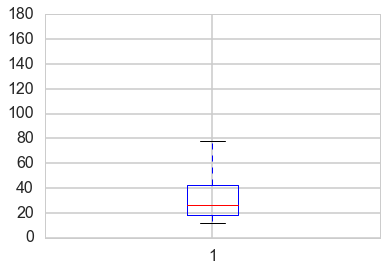

In [30]:
plt.boxplot(dp[(dp.command == 'NAVIGATE')].duration.values)

In [31]:
dpnavdur = dp[(dp.command == 'NAVIGATE')]
dpnavdur.drop(['level_0', 'index', 'c3'], axis=1, inplace=True)
dpnavdur.to_csv('/Volumes/group/awagner/sgagnon/SST/analysis/nav/group_nav_durations.csv', index=False)

/Users/steph-backup/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


#### Distribution of min navigation times

In [32]:
dp[(dp.command == 'NAVIGATE')].groupby(['subid']).min().reset_index().duration.values

array([ 19.662,  14.626,  13.58 ,  17.19 ,  12.768,  16.257,  14.182,
        13.67 ,  13.99 ,  12.356,  14.43 ,  15.84 ,  12.39 ,  13.38 ,
        12.08 ,  12.94 ,  11.906])

In [33]:
dp.head()

,level_0,index,time,command,c3,subid,run,type,duration
0,3,3,19.294,NAVIGATE,started_navigation,1,1,habit,49.284
1,7,7,101.556,NAVIGATE,started_navigation,1,1,habit,38.016
2,11,11,172.586,NAVIGATE,started_navigation,1,1,habit,42.686
3,16,16,19.225,NAVIGATE,started_navigation,1,2,habit,48.342
4,20,20,100.581,NAVIGATE,started_navigation,1,2,habit,58.488


## Add environment labels to df

In [34]:
trial_order.head()

,subid,rep,run,trial,env
0,1,1,1,1,1
1,1,1,1,2,8
2,1,1,1,3,9
3,1,1,2,1,4
4,1,1,2,2,5


In [35]:
dp.drop(['level_0', 'index'], axis=1, inplace=True)
dp = dp.sort(columns=['subid', 'run', 'time']).reset_index()
dp.head()

/Users/steph-backup/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,index,time,command,c3,subid,run,type,duration
0,1218,0.278,ORIENT,oriented_to_env,1,1,habit,11.000
1,1827,11.308,ASSIGNED,zzz,1,1,habit,8.000
2,0,19.294,NAVIGATE,started_navigation,1,1,habit,49.284
3,609,68.578,ARRIVED,zzz,1,1,habit,1.000
4,1219,82.554,ORIENT,oriented_to_env,1,1,habit,11.000


In [36]:
orient_onsets = dp.loc[dp.command == 'ORIENT']
orient_onsets.drop(['index'], axis=1, inplace=True)
orient_onsets.head()

/Users/steph-backup/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,time,command,c3,subid,run,type,duration
0,0.278,ORIENT,oriented_to_env,1,1,habit,11
4,82.554,ORIENT,oriented_to_env,1,1,habit,11
8,153.566,ORIENT,oriented_to_env,1,1,habit,11
12,0.205,ORIENT,oriented_to_env,1,2,habit,11
16,81.543,ORIENT,oriented_to_env,1,2,habit,11


In [37]:
orient_onsets['trial'] = 0 # init trial number

for counter, ind in enumerate(orient_onsets.index):
    if counter == 0: # first trial
        first_ind = ind
        orient_onsets.loc[ind, 'trial'] = 1
        prev_ind = ind
    else:
        if orient_onsets.loc[ind, 'run'] == orient_onsets.loc[prev_ind, 'run']:
            orient_onsets.loc[ind, 'trial'] = orient_onsets.loc[prev_ind, 'trial'] + 1
            prev_ind = ind
        else:
            orient_onsets.loc[ind, 'trial'] = 1
            prev_ind = ind

/Users/steph-backup/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/steph-backup/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [38]:
orient_onsets.head()

,time,command,c3,subid,run,type,duration,trial
0,0.278,ORIENT,oriented_to_env,1,1,habit,11,1
4,82.554,ORIENT,oriented_to_env,1,1,habit,11,2
8,153.566,ORIENT,oriented_to_env,1,1,habit,11,3
12,0.205,ORIENT,oriented_to_env,1,2,habit,11,1
16,81.543,ORIENT,oriented_to_env,1,2,habit,11,2


In [39]:
orient_onsets = orient_onsets.reset_index().merge(trial_order)
orient_onsets.head()

,index,time,command,c3,subid,run,type,duration,trial,rep,env
0,0,0.278,ORIENT,oriented_to_env,1,1,habit,11,1,1,1
1,4,82.554,ORIENT,oriented_to_env,1,1,habit,11,2,1,8
2,8,153.566,ORIENT,oriented_to_env,1,1,habit,11,3,1,9
3,12,0.205,ORIENT,oriented_to_env,1,2,habit,11,1,1,4
4,16,81.543,ORIENT,oriented_to_env,1,2,habit,11,2,1,5


In [40]:
dp.head()

,index,time,command,c3,subid,run,type,duration
0,1218,0.278,ORIENT,oriented_to_env,1,1,habit,11.000
1,1827,11.308,ASSIGNED,zzz,1,1,habit,8.000
2,0,19.294,NAVIGATE,started_navigation,1,1,habit,49.284
3,609,68.578,ARRIVED,zzz,1,1,habit,1.000
4,1219,82.554,ORIENT,oriented_to_env,1,1,habit,11.000


In [41]:
dp['env'] = np.nan
dp['rep'] = np.nan
dp['trial'] = np.nan

for i in orient_onsets.index:
    index_val = orient_onsets.loc[i, 'index']
    dp.loc[index_val, 'env'] = 'env' + orient_onsets.loc[i, 'env'].astype(str)
    dp.loc[index_val, 'rep'] = orient_onsets.loc[i, 'rep']
    dp.loc[index_val, 'trial'] = orient_onsets.loc[i, 'trial']

dp.env.fillna(method='ffill', inplace=True)
dp.rep.fillna(method='ffill', inplace=True)
dp.trial.fillna(method='ffill', inplace=True)
dp.head()

,index,time,command,c3,subid,run,type,duration,env,rep,trial
0,1218,0.278,ORIENT,oriented_to_env,1,1,habit,11.000,env1,1,1
1,1827,11.308,ASSIGNED,zzz,1,1,habit,8.000,env1,1,1
2,0,19.294,NAVIGATE,started_navigation,1,1,habit,49.284,env1,1,1
3,609,68.578,ARRIVED,zzz,1,1,habit,1.000,env1,1,1
4,1219,82.554,ORIENT,oriented_to_env,1,1,habit,11.000,env8,1,2


In [42]:
print len('env' + orient_onsets.env.astype(str))
print len(dp.loc[orient_onsets['index'], 'env'])

609
609


In [69]:
dp.head()

,index,time,command,c3,subid,run,type,duration,env,rep,trial
0,1218,0.278,ORIENT,oriented_to_env,1,1,habit,11.000,env1,1,1
1,1827,11.308,ASSIGNED,zzz,1,1,habit,8.000,env1,1,1
2,0,19.294,NAVIGATE,started_navigation,1,1,habit,49.284,env1,1,1
3,609,68.578,ARRIVED,zzz,1,1,habit,1.000,env1,1,1
4,1219,82.554,ORIENT,oriented_to_env,1,1,habit,11.000,env8,1,2


### Merge onsets w/route taken

In [130]:
dp_byenv = dp.copy()
dp_byenv.head()

,index,time,command,c3,subid,run,type,duration,env,rep,trial
0,1218,0.278,ORIENT,oriented_to_env,1,1,habit,11.000,env1,1,1
1,1827,11.308,ASSIGNED,zzz,1,1,habit,8.000,env1,1,1
2,0,19.294,NAVIGATE,started_navigation,1,1,habit,49.284,env1,1,1
3,609,68.578,ARRIVED,zzz,1,1,habit,1.000,env1,1,1
4,1219,82.554,ORIENT,oriented_to_env,1,1,habit,11.000,env8,1,2


#### Load in route coding

In [131]:
df_routecoding =  pd.read_csv('/Volumes/group/awagner/sgagnon/SST/nav_data/route_coding.csv')

df_routecoding['env'] = 'env' + df_routecoding['env'].astype(str)
df_routecoding['subid'] = df_routecoding.subid.str.replace('sst', '').astype(int)
df_routecoding['subid'] = df_routecoding.subid.astype(str)
df_routecoding.rename(columns={'run_type': 'type'}, inplace=True)

df_routecoding.head()

,subid,env,type,rep,code1
0,1,env1,habit,1,habit
1,1,env1,shortcut,1,other
2,1,env1,shortcut,2,habit
3,1,env2,habit,1,habit
4,1,env2,shortcut,1,habit


In [132]:
dp_byenv = dp_byenv.merge(df_routecoding)
dp_byenv.head()

,index,time,command,c3,subid,run,type,duration,env,rep,trial,code1
0,1218,0.278,ORIENT,oriented_to_env,1,1,habit,11.000,env1,1,1,habit
1,1827,11.308,ASSIGNED,zzz,1,1,habit,8.000,env1,1,1,habit
2,0,19.294,NAVIGATE,started_navigation,1,1,habit,49.284,env1,1,1,habit
3,609,68.578,ARRIVED,zzz,1,1,habit,1.000,env1,1,1,habit
4,1219,82.554,ORIENT,oriented_to_env,1,1,habit,11.000,env8,1,2,other


In [137]:
df_routecoding.loc[df_routecoding.code1.isnull()]

,subid,env,type,rep,code1
345,11,env8,habit,1,NaN
348,11,env9,habit,1,NaN
456,14,env9,habit,1,NaN


In [136]:
print dp.shape
print dp_byenv.shape

(2436, 11)
(2436, 12)


In [126]:
dp_byenv.loc[dp_byenv.code1.isnull()]

,index,time,command,c3,subid,run,type,duration,env,rep,trial,code1


## Generate onsets 

In [43]:
output_filename = 'nav_cond.csv'
output_dir = '/Volumes/group/awagner/sgagnon/SST/data'

for sub in subj_info.subid:
    print sub
    
    dsub = dp[(dp.subid == sub)]
    ddesign = pd.DataFrame({'run': dsub.run, 
                            'condition': dsub.command,
                            'onset': dsub.time,
                            'duration': dsub.duration,
                            'value': 1})
    
    # model some things as impulse rather than boxcar:
    ddesign.loc[ddesign.condition.isin(['ASSIGNED', 'ARRIVED']), 'duration'] = 0
    
    if int(sub) < 10:
        sub_output_dir = op.join(output_dir, 'sst0' + str(sub), 'design')
    else:
        sub_output_dir = op.join(output_dir, 'sst' + str(sub), 'design')
        
    print sub_output_dir
    
    if not os.path.exists(sub_output_dir):
        os.makedirs(sub_output_dir)
    
    ddesign.to_csv(op.join(sub_output_dir, output_filename), index=False)

1
/Volumes/group/awagner/sgagnon/SST/data/sst01/design
2
/Volumes/group/awagner/sgagnon/SST/data/sst02/design
3
/Volumes/group/awagner/sgagnon/SST/data/sst03/design
4
/Volumes/group/awagner/sgagnon/SST/data/sst04/design
5
/Volumes/group/awagner/sgagnon/SST/data/sst05/design
6
/Volumes/group/awagner/sgagnon/SST/data/sst06/design
7
/Volumes/group/awagner/sgagnon/SST/data/sst07/design
9
/Volumes/group/awagner/sgagnon/SST/data/sst09/design
10
/Volumes/group/awagner/sgagnon/SST/data/sst10/design
11
/Volumes/group/awagner/sgagnon/SST/data/sst11/design
12
/Volumes/group/awagner/sgagnon/SST/data/sst12/design
13
/Volumes/group/awagner/sgagnon/SST/data/sst13/design
14
/Volumes/group/awagner/sgagnon/SST/data/sst14/design
15
/Volumes/group/awagner/sgagnon/SST/data/sst15/design
16
/Volumes/group/awagner/sgagnon/SST/data/sst16/design
18
/Volumes/group/awagner/sgagnon/SST/data/sst18/design
19
/Volumes/group/awagner/sgagnon/SST/data/sst19/design


In [118]:
output_filename = 'nav_cond_byruntype.csv'
output_dir = '/Volumes/group/awagner/sgagnon/SST/data'

for sub in subj_info.subid:
    print sub
    
    dsub = dp[(dp.subid == sub)]
    ddesign = pd.DataFrame({'run': dsub.run, 
                            'condition': dsub.command + '_' + dsub['type'],
                            'onset': dsub.time,
                            'duration': dsub.duration,
                            'value': 1})
    
    # model some things as impulse rather than boxcar:
    ddesign.loc[ddesign.condition.isin(['ASSIGNED_shortcut', 'ARRIVED_shortcut',
                                        'ASSIGNED_habit', 'ARRIVED_habit']), 'duration'] = 0
    
    if int(sub) < 10:
        sub_output_dir = op.join(output_dir, 'sst0' + str(sub), 'design')
    else:
        sub_output_dir = op.join(output_dir, 'sst' + str(sub), 'design')
        
    print sub_output_dir
    
    if not os.path.exists(sub_output_dir):
        os.makedirs(sub_output_dir)
    
    ddesign.to_csv(op.join(sub_output_dir, output_filename), index=False)

1
/Volumes/group/awagner/sgagnon/SST/data/sst01/design
2
/Volumes/group/awagner/sgagnon/SST/data/sst02/design
3
/Volumes/group/awagner/sgagnon/SST/data/sst03/design
4
/Volumes/group/awagner/sgagnon/SST/data/sst04/design
5
/Volumes/group/awagner/sgagnon/SST/data/sst05/design
6
/Volumes/group/awagner/sgagnon/SST/data/sst06/design
7
/Volumes/group/awagner/sgagnon/SST/data/sst07/design
9
/Volumes/group/awagner/sgagnon/SST/data/sst09/design
10
/Volumes/group/awagner/sgagnon/SST/data/sst10/design
11
/Volumes/group/awagner/sgagnon/SST/data/sst11/design
12
/Volumes/group/awagner/sgagnon/SST/data/sst12/design
13
/Volumes/group/awagner/sgagnon/SST/data/sst13/design
14
/Volumes/group/awagner/sgagnon/SST/data/sst14/design
15
/Volumes/group/awagner/sgagnon/SST/data/sst15/design
16
/Volumes/group/awagner/sgagnon/SST/data/sst16/design
18
/Volumes/group/awagner/sgagnon/SST/data/sst18/design
19
/Volumes/group/awagner/sgagnon/SST/data/sst19/design


In [138]:
dp.head()

,index,time,command,c3,subid,run,type,duration,env,rep,trial
0,1218,0.278,ORIENT,oriented_to_env,1,1,habit,11.000,env1,1,1
1,1827,11.308,ASSIGNED,zzz,1,1,habit,8.000,env1,1,1
2,0,19.294,NAVIGATE,started_navigation,1,1,habit,49.284,env1,1,1
3,609,68.578,ARRIVED,zzz,1,1,habit,1.000,env1,1,1
4,1219,82.554,ORIENT,oriented_to_env,1,1,habit,11.000,env8,1,2


In [139]:
dp_byenv['cond_label'] = dp_byenv.command + '_' + dp_byenv['type']
dp_byenv.loc[dp_byenv['type'] == 'shortcut', 'cond_label'] = dp_byenv.command + '_' + dp_byenv['type'] + '_TAKE' + dp_byenv.code1

dp_byenv['duration_foronsetfile'] = dp_byenv.duration
dp_byenv.loc[dp_byenv.command.isin(['ARRIVED', 'ASSIGNED']),'duration_foronsetfile'] = 0

dp_byenv.head()

,index,time,command,c3,subid,run,type,duration,env,rep,trial,code1,cond_label,duration_foronsetfile
0,1218,0.278,ORIENT,oriented_to_env,1,1,habit,11.000,env1,1,1,habit,ORIENT_habit,11.000
1,1827,11.308,ASSIGNED,zzz,1,1,habit,8.000,env1,1,1,habit,ASSIGNED_habit,0.000
2,0,19.294,NAVIGATE,started_navigation,1,1,habit,49.284,env1,1,1,habit,NAVIGATE_habit,49.284
3,609,68.578,ARRIVED,zzz,1,1,habit,1.000,env1,1,1,habit,ARRIVED_habit,0.000
4,1219,82.554,ORIENT,oriented_to_env,1,1,habit,11.000,env8,1,2,other,ORIENT_habit,11.000


### Determine trial counts

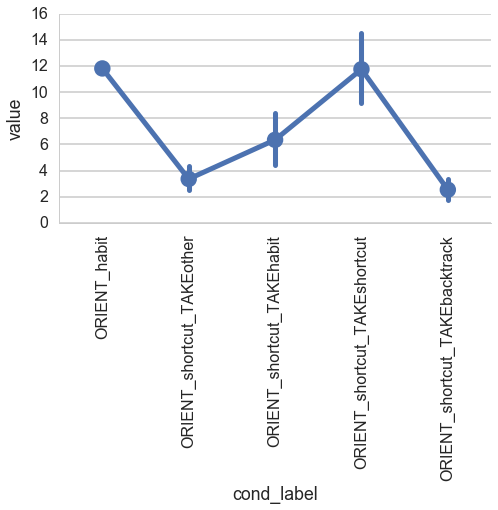

In [164]:
dp_o = dp_byenv.loc[dp_byenv.command == 'ORIENT'].groupby(['subid', 'cond_label']).count().reset_index()
dp_o = dp_o.pivot_table(values='env', index='subid', columns='cond_label', fill_value=0).reset_index()
dp_o = pd.melt(dp_o, id_vars='subid', value_vars=list(dp_byenv.loc[dp_byenv.command == 'ORIENT'].cond_label.unique()))

g = sns.factorplot(x='cond_label', y='value', units='subid', ci=95, data=dp_o, aspect=2)
g.set_xticklabels(rotation=90)

In [163]:
dp_o.loc[dp_o.value < 2]

,subid,cond_label,value
21,13,ORIENT_shortcut_TAKEother,1
23,15,ORIENT_shortcut_TAKEother,0
27,2,ORIENT_shortcut_TAKEother,1
46,4,ORIENT_shortcut_TAKEhabit,1
50,9,ORIENT_shortcut_TAKEhabit,1
75,16,ORIENT_shortcut_TAKEbacktrack,0
77,19,ORIENT_shortcut_TAKEbacktrack,1
80,4,ORIENT_shortcut_TAKEbacktrack,1
82,6,ORIENT_shortcut_TAKEbacktrack,1
83,7,ORIENT_shortcut_TAKEbacktrack,1


In [140]:
output_filename = 'nav_cond_byruntype_byroute.csv'
output_dir = '/Volumes/group/awagner/sgagnon/SST/data'

for sub in subj_info.subid:
    print sub
     
    dsub = dp_byenv[(dp_byenv.subid == sub)]
    ddesign = pd.DataFrame({'run': dsub.run, 
                            'condition': dsub.cond_label,
                            'onset': dsub.time,
                            'duration': dsub.duration_foronsetfile,
                            'value': 1})
        
    if int(sub) < 10:
        sub_output_dir = op.join(output_dir, 'sst0' + str(sub), 'design')
    else:
        sub_output_dir = op.join(output_dir, 'sst' + str(sub), 'design')
        
    print sub_output_dir
    
    if not os.path.exists(sub_output_dir):
        os.makedirs(sub_output_dir)
    
    ddesign.to_csv(op.join(sub_output_dir, output_filename), index=False)

1
/Volumes/group/awagner/sgagnon/SST/data/sst01/design
2
/Volumes/group/awagner/sgagnon/SST/data/sst02/design
3
/Volumes/group/awagner/sgagnon/SST/data/sst03/design
4
/Volumes/group/awagner/sgagnon/SST/data/sst04/design
5
/Volumes/group/awagner/sgagnon/SST/data/sst05/design
6
/Volumes/group/awagner/sgagnon/SST/data/sst06/design
7
/Volumes/group/awagner/sgagnon/SST/data/sst07/design
9
/Volumes/group/awagner/sgagnon/SST/data/sst09/design
10
/Volumes/group/awagner/sgagnon/SST/data/sst10/design
11
/Volumes/group/awagner/sgagnon/SST/data/sst11/design
12
/Volumes/group/awagner/sgagnon/SST/data/sst12/design
13
/Volumes/group/awagner/sgagnon/SST/data/sst13/design
14
/Volumes/group/awagner/sgagnon/SST/data/sst14/design
15
/Volumes/group/awagner/sgagnon/SST/data/sst15/design
16
/Volumes/group/awagner/sgagnon/SST/data/sst16/design
18
/Volumes/group/awagner/sgagnon/SST/data/sst18/design
19
/Volumes/group/awagner/sgagnon/SST/data/sst19/design


In [45]:
output_filename = 'nav_cond_byenv.csv'
output_dir = '/Volumes/group/awagner/sgagnon/SST/data'

for sub in subj_info.subid:
    print sub
    
    dsub = dp[(dp.subid == sub)]
    dsub['command_detailed'] = dsub.command + '_' + dsub['type'] + '_' + dsub.env + '_rep' + dsub.rep.map(int).map(str)
    ddesign = pd.DataFrame({'run': dsub.run, 
                            'condition': dsub.command_detailed, 
                            'onset': dsub.time,
                            'duration': dsub.duration,
                            'value': 1})
    
    # model some things as impulse rather than boxcar:
    ddesign.loc[ddesign.condition.isin(['ASSIGNED', 'ARRIVED']), 'duration'] = 0
    
    if int(sub) < 10:
        sub_output_dir = op.join(output_dir, 'sst0' + str(sub), 'design')
    else:
        sub_output_dir = op.join(output_dir, 'sst' + str(sub), 'design')
        
    print sub_output_dir
    
    if not os.path.exists(sub_output_dir):
        os.makedirs(sub_output_dir)
    
    ddesign.to_csv(op.join(sub_output_dir, output_filename), index=False)

1
/Volumes/group/awagner/sgagnon/SST/data/sst01/design
2
/Volumes/group/awagner/sgagnon/SST/data/sst02/design
3
/Volumes/group/awagner/sgagnon/SST/data/sst03/design
4
/Volumes/group/awagner/sgagnon/SST/data/sst04/design
5
/Volumes/group/awagner/sgagnon/SST/data/sst05/design
6
/Volumes/group/awagner/sgagnon/SST/data/sst06/design
7
/Volumes/group/awagner/sgagnon/SST/data/sst07/design
9
/Volumes/group/awagner/sgagnon/SST/data/sst09/design
10
/Volumes/group/awagner/sgagnon/SST/data/sst10/design
11
/Volumes/group/awagner/sgagnon/SST/data/sst11/design
12
/Volumes/group/awagner/sgagnon/SST/data/sst12/design
13
/Volumes/group/awagner/sgagnon/SST/data/sst13/design
14
/Volumes/group/awagner/sgagnon/SST/data/sst14/design
15
/Volumes/group/awagner/sgagnon/SST/data/sst15/design
16
/Volumes/group/awagner/sgagnon/SST/data/sst16/design
18
/Volumes/group/awagner/sgagnon/SST/data/sst18/design
19
/Volumes/group/awagner/sgagnon/SST/data/sst19/design


/Users/steph-backup/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## If just modeling the "orient" period to remove that variance from model.

In [45]:
output_filename = 'nav_ORIENT.csv'
output_dir = '/Volumes/group/awagner/sgagnon/SST/data'

dp_orient = dp.loc[dp.command == 'ORIENT']

for sub in subj_info.subid:
    print sub
    
    dsub = dp_orient[(dp_orient.subid == sub)]
    ddesign = pd.DataFrame({'run': dsub.run, 
                            'condition': dsub.command,
                            'onset': dsub.time,
                            'duration': dsub.duration,
                            'value': 1})
        
    if int(sub) < 10:
        sub_output_dir = op.join(output_dir, 'sst0' + str(sub), 'design')
    else:
        sub_output_dir = op.join(output_dir, 'sst' + str(sub), 'design')
        
    print sub_output_dir
    
    if not os.path.exists(sub_output_dir):
        os.makedirs(sub_output_dir)
    
    ddesign.to_csv(op.join(sub_output_dir, output_filename), index=False)

1
/Volumes/group/awagner/sgagnon/SST/data/sst01/design
2
/Volumes/group/awagner/sgagnon/SST/data/sst02/design
3
/Volumes/group/awagner/sgagnon/SST/data/sst03/design
4
/Volumes/group/awagner/sgagnon/SST/data/sst04/design
5
/Volumes/group/awagner/sgagnon/SST/data/sst05/design
6
/Volumes/group/awagner/sgagnon/SST/data/sst06/design
7
/Volumes/group/awagner/sgagnon/SST/data/sst07/design
9
/Volumes/group/awagner/sgagnon/SST/data/sst09/design
10
/Volumes/group/awagner/sgagnon/SST/data/sst10/design
11
/Volumes/group/awagner/sgagnon/SST/data/sst11/design
12
/Volumes/group/awagner/sgagnon/SST/data/sst12/design
13
/Volumes/group/awagner/sgagnon/SST/data/sst13/design
14
/Volumes/group/awagner/sgagnon/SST/data/sst14/design
15
/Volumes/group/awagner/sgagnon/SST/data/sst15/design
16
/Volumes/group/awagner/sgagnon/SST/data/sst16/design
18
/Volumes/group/awagner/sgagnon/SST/data/sst18/design
19
/Volumes/group/awagner/sgagnon/SST/data/sst19/design
